# $\textbf{Part 1. Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

#### $\textbf{Prediction of LFSR State }n + 1\textbf{ Given State }n$
$\text{Suppose we are given an arbitrary LFSR feedback polynomial and we build a representation of the LFSR in software. Using this LFSR, and}$
$\text{assuming the feedback polynomial is primitive in a polynomial ring of fixed degree over }GF(2)\text{, we can generate a maximum-length binary}$
$\text{sequence which has well-documented correlation properties which make them desirable building blocks for stream ciphers or spread-spectrum}$
$\text{codes, to name a few examples. On their own, LFSRs do not afford any real cryptographic protection, being famously susceptible to correlation}$
$\text{attacks. Speaking of attacks, our goal in this notebook is to demonstrate that we can use a }\textit{very}\text{ simple neural network to predict LFSR behavior.}$
$\text{Specifically, we posit that a two-layer (i.e., single hidden-layer) feedforward neural network can readily predict the state-evolution of an arbitrary}$
$\text{LFSR. For simplicity, we constrain this network to have a very specific architecture. Its input layer consists of a fixed-length binary vector that}$
$\text{represents the LFSR state vector at some time index (epoch) }n\text{. We use the ground truth register state at index / epoch }n + 1\text{ to train a the network}$
$\text{to develop a latent representation of the finite field recursion. Both layers of the network are sigmoid connections, representing soft approximations}$
$\text{of boolean gates, outputing activations in the unit interval, }[0,1].\text{ These layers assume no bias terms, only weighted combinations of inputs. For}$
$\text{an LFSR of recursion-order/polynomial degree }deg\text{, the first (and only) hidden layer consists a total of }2\times deg\text{ weighted sigmoidal activations.}$
$\text{The output layer consists of the }deg\text{ total activations predicting }deg\text{ total bits in the LFSR state vector at epoch }n + 1\text{, for all }n\text{. These binary}$
$\text{activations are trained against the true LFSR state vectors at these indices }n + 1\text{ using a binary cross-entropy error function. The population of}$
$\text{observations are the }deg\text{-length LFSR states across all epochs in one full }m\text{-sequence period / cycle. The labels for the error function are the }$
$deg\text{-length state vector values upon 1 iteration of the LFSR recursion, per observation.}$

#### $\textbf{Part 1 of This Notebook}$
$\text{Part 1 of this notebook prototypes a feedforward binary (bias-less) neural network using Keras, training it as described above using RMSprop. The}$
$\text{model is given too few degrees of freedom to completely memorize the bits, so it must learn a latent representation of the underlying finite field}$
$\text{mathematics defining the recurrence relation. After sufficiently many training epochs, the model has been tested to converge to 100}\%\text{ accuracy}$
$\text{for all degree-10 primitive polynomials in the file 10.txt. Primitive polynomials defining }m\text{-sequences for other polynomial degrees are available}$
$\text{for download at the following site: }\textit{https://users.ece.cmu.edu/~koopman/lfsr/index.html}\text{. Future efforts may build this proof-of-concept out to}$
$\text{higher degree recursions and more complicated kinds of stream ciphers. For now, we demonstrate that a relatively shallow binary network is}$
$\text{sufficiently powerful to "crack" (i.e., predict) an LFSR's underlying recursive state vector mapping.}$

$\text{In addition to training the network, we animate the results in a plot which depicts the time-evolution of the LFSR recursion and the neural}$
$\text{network's state predictions. In addition, options are provided for plotting the correlation properties of the }m\text{-sequence training data and the Keras}$
$\text{model metrics vs training epoch, respectively. Documentation and source code for all the functions below can be found in this repo's modules.}$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 16000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

# Turn ON/OFF true vs. predicted mask plot
plot_prediction_masks = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg,
    path='./primitive_polynomials/')

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


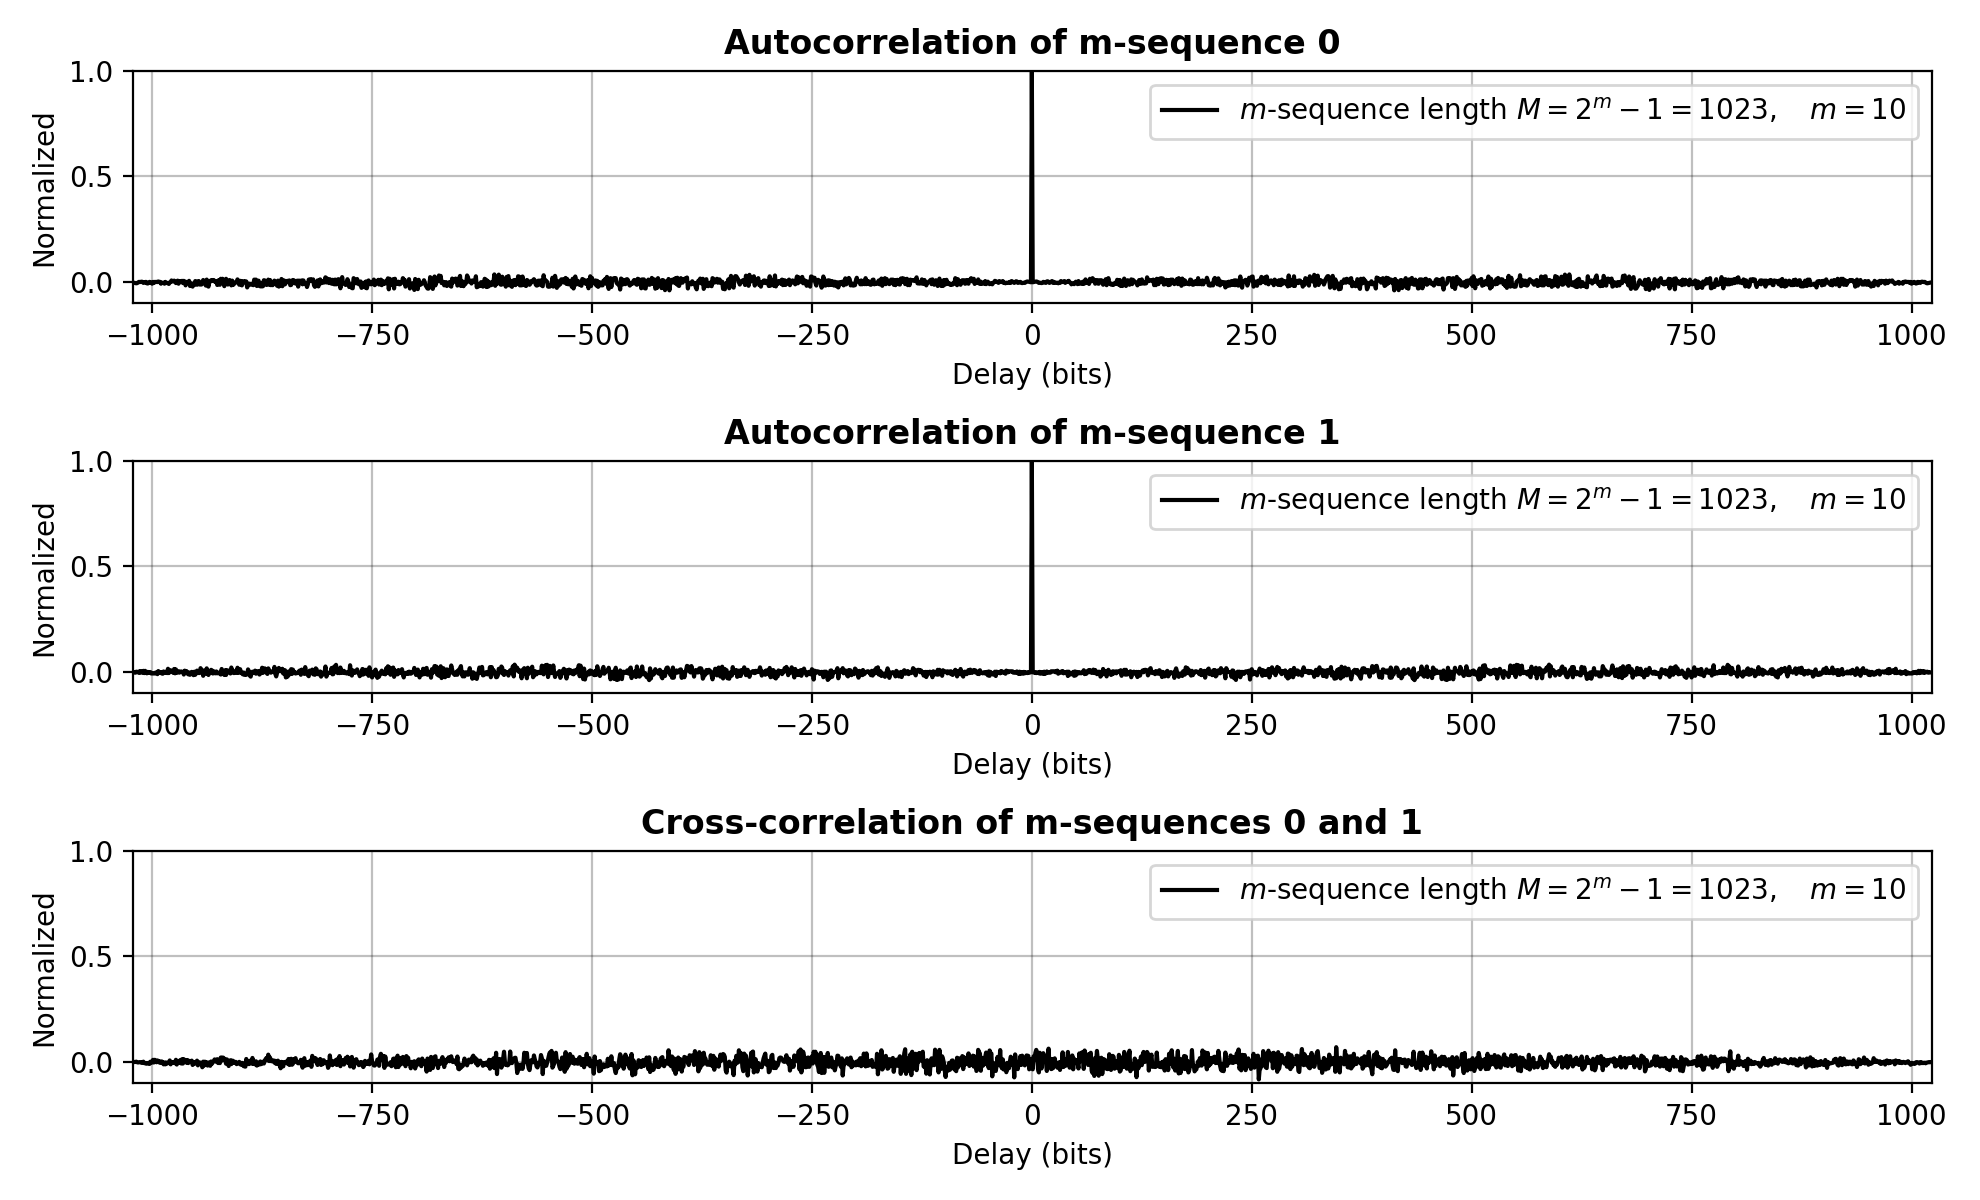

In [13]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/16000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7457 - true_positives: 2130.0000 - true_negatives: 3048.0000 - false_positives: 2062.0000 - false_negatives: 2990.0000
Epoch 2/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7407 - true_positives: 2170.0000 - true_negatives: 3024.0000 - false_positives: 2086.0000 - false_negatives: 2950.0000
Epoch 3/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7373 - true_positives: 2198.0000 - true_negatives: 3011.0000 - false_positives: 2099.0000 - false_negatives: 2922.0000
Epoch 4/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7346 - true_positives: 2223.0000 - true_negatives: 3004.0000 - false_positives: 2106.0000 - false_negatives: 2897.0000
Epoch 5/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7323 - true_positives: 2248.0000 - true_negatives: 2997.0000 - false_positives: 2113.00

Epoch 42/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6925 - true_positives: 3223.0000 - true_negatives: 2959.0000 - false_positives: 2151.0000 - false_negatives: 1897.0000
Epoch 43/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6918 - true_positives: 3253.0000 - true_negatives: 2959.0000 - false_positives: 2151.0000 - false_negatives: 1867.0000
Epoch 44/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6910 - true_positives: 3288.0000 - true_negatives: 2957.0000 - false_positives: 2153.0000 - false_negatives: 1832.0000
Epoch 45/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6903 - true_positives: 3316.0000 - true_negatives: 2953.0000 - false_positives: 2157.0000 - false_negatives: 1804.0000
Epoch 46/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6896 - true_positives: 3338.0000 - true_negatives: 2946.0000 - false_positives: 2164.0000 - false_negati

Epoch 83/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6667 - true_positives: 4207.0000 - true_negatives: 2929.0000 - false_positives: 2181.0000 - false_negatives: 913.0000
Epoch 84/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6662 - true_positives: 4221.0000 - true_negatives: 2935.0000 - false_positives: 2175.0000 - false_negatives: 899.0000
Epoch 85/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6657 - true_positives: 4240.0000 - true_negatives: 2935.0000 - false_positives: 2175.0000 - false_negatives: 880.0000
Epoch 86/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6651 - true_positives: 4254.0000 - true_negatives: 2935.0000 - false_positives: 2175.0000 - false_negatives: 866.0000
Epoch 87/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6646 - true_positives: 4265.0000 - true_negatives: 2943.0000 - false_positives: 2167.0000 - false_negatives:

Epoch 124/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6471 - true_positives: 4419.0000 - true_negatives: 3372.0000 - false_positives: 1738.0000 - false_negatives: 701.0000
Epoch 125/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6467 - true_positives: 4415.0000 - true_negatives: 3387.0000 - false_positives: 1723.0000 - false_negatives: 705.0000
Epoch 126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6462 - true_positives: 4412.0000 - true_negatives: 3402.0000 - false_positives: 1708.0000 - false_negatives: 708.0000
Epoch 127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6458 - true_positives: 4412.0000 - true_negatives: 3423.0000 - false_positives: 1687.0000 - false_negatives: 708.0000
Epoch 128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6453 - true_positives: 4406.0000 - true_negatives: 3443.0000 - false_positives: 1667.0000 - false_negat

Epoch 165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6285 - true_positives: 4477.0000 - true_negatives: 3789.0000 - false_positives: 1321.0000 - false_negatives: 643.0000
Epoch 166/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6280 - true_positives: 4479.0000 - true_negatives: 3796.0000 - false_positives: 1314.0000 - false_negatives: 641.0000
Epoch 167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6276 - true_positives: 4481.0000 - true_negatives: 3801.0000 - false_positives: 1309.0000 - false_negatives: 639.0000
Epoch 168/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6271 - true_positives: 4483.0000 - true_negatives: 3815.0000 - false_positives: 1295.0000 - false_negatives: 637.0000
Epoch 169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6266 - true_positives: 4484.0000 - true_negatives: 3816.0000 - false_positives: 1294.0000 - false_negat

Epoch 206/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6091 - true_positives: 4520.0000 - true_negatives: 4030.0000 - false_positives: 1080.0000 - false_negatives: 600.0000
Epoch 207/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6086 - true_positives: 4523.0000 - true_negatives: 4032.0000 - false_positives: 1078.0000 - false_negatives: 597.0000
Epoch 208/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6081 - true_positives: 4524.0000 - true_negatives: 4036.0000 - false_positives: 1074.0000 - false_negatives: 596.0000
Epoch 209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6076 - true_positives: 4523.0000 - true_negatives: 4039.0000 - false_positives: 1071.0000 - false_negatives: 597.0000
Epoch 210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6071 - true_positives: 4523.0000 - true_negatives: 4048.0000 - false_positives: 1062.0000 - false_negat

Epoch 247/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5889 - true_positives: 4549.0000 - true_negatives: 4214.0000 - false_positives: 896.0000 - false_negatives: 571.0000
Epoch 248/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5884 - true_positives: 4570.0000 - true_negatives: 4207.0000 - false_positives: 903.0000 - false_negatives: 550.0000
Epoch 249/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5879 - true_positives: 4555.0000 - true_negatives: 4222.0000 - false_positives: 888.0000 - false_negatives: 565.0000
Epoch 250/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5874 - true_positives: 4569.0000 - true_negatives: 4217.0000 - false_positives: 893.0000 - false_negatives: 551.0000
Epoch 251/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5869 - true_positives: 4557.0000 - true_negatives: 4229.0000 - false_positives: 881.0000 - false_negatives:

Epoch 288/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5680 - true_positives: 4588.0000 - true_negatives: 4361.0000 - false_positives: 749.0000 - false_negatives: 532.0000
Epoch 289/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5675 - true_positives: 4567.0000 - true_negatives: 4376.0000 - false_positives: 734.0000 - false_negatives: 553.0000
Epoch 290/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5669 - true_positives: 4589.0000 - true_negatives: 4366.0000 - false_positives: 744.0000 - false_negatives: 531.0000
Epoch 291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5664 - true_positives: 4567.0000 - true_negatives: 4382.0000 - false_positives: 728.0000 - false_negatives: 553.0000
Epoch 292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5659 - true_positives: 4589.0000 - true_negatives: 4369.0000 - false_positives: 741.0000 - false_negatives:

Epoch 329/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5464 - true_positives: 4582.0000 - true_negatives: 4483.0000 - false_positives: 627.0000 - false_negatives: 538.0000
Epoch 330/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5459 - true_positives: 4611.0000 - true_negatives: 4467.0000 - false_positives: 643.0000 - false_negatives: 509.0000
Epoch 331/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5453 - true_positives: 4580.0000 - true_negatives: 4489.0000 - false_positives: 621.0000 - false_negatives: 540.0000
Epoch 332/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5448 - true_positives: 4611.0000 - true_negatives: 4471.0000 - false_positives: 639.0000 - false_negatives: 509.0000
Epoch 333/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5443 - true_positives: 4582.0000 - true_negatives: 4494.0000 - false_positives: 616.0000 - false_negatives:

Epoch 370/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5245 - true_positives: 4620.0000 - true_negatives: 4520.0000 - false_positives: 590.0000 - false_negatives: 500.0000
Epoch 371/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5240 - true_positives: 4572.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 548.0000
Epoch 372/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5234 - true_positives: 4621.0000 - true_negatives: 4522.0000 - false_positives: 588.0000 - false_negatives: 499.0000
Epoch 373/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5229 - true_positives: 4573.0000 - true_negatives: 4560.0000 - false_positives: 550.0000 - false_negatives: 547.0000
Epoch 374/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5224 - true_positives: 4623.0000 - true_negatives: 4529.0000 - false_positives: 581.0000 - false_negatives:

Epoch 411/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5025 - true_positives: 4574.0000 - true_negatives: 4608.0000 - false_positives: 502.0000 - false_negatives: 546.0000
Epoch 412/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5020 - true_positives: 4645.0000 - true_negatives: 4547.0000 - false_positives: 563.0000 - false_negatives: 475.0000
Epoch 413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5015 - true_positives: 4575.0000 - true_negatives: 4612.0000 - false_positives: 498.0000 - false_negatives: 545.0000
Epoch 414/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5009 - true_positives: 4647.0000 - true_negatives: 4544.0000 - false_positives: 566.0000 - false_negatives: 473.0000
Epoch 415/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5004 - true_positives: 4573.0000 - true_negatives: 4611.0000 - false_positives: 499.0000 - false_negatives:

Epoch 452/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4807 - true_positives: 4683.0000 - true_negatives: 4547.0000 - false_positives: 563.0000 - false_negatives: 437.0000
Epoch 453/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4802 - true_positives: 4588.0000 - true_negatives: 4640.0000 - false_positives: 470.0000 - false_negatives: 532.0000
Epoch 454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4796 - true_positives: 4684.0000 - true_negatives: 4545.0000 - false_positives: 565.0000 - false_negatives: 436.0000
Epoch 455/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4791 - true_positives: 4587.0000 - true_negatives: 4639.0000 - false_positives: 471.0000 - false_negatives: 533.0000
Epoch 456/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4786 - true_positives: 4682.0000 - true_negatives: 4548.0000 - false_positives: 562.0000 - false_negatives:

Epoch 493/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4592 - true_positives: 4614.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 506.0000
Epoch 494/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4586 - true_positives: 4706.0000 - true_negatives: 4567.0000 - false_positives: 543.0000 - false_negatives: 414.0000
Epoch 495/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4581 - true_positives: 4613.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives: 507.0000
Epoch 496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4576 - true_positives: 4708.0000 - true_negatives: 4568.0000 - false_positives: 542.0000 - false_negatives: 412.0000
Epoch 497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4571 - true_positives: 4611.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives:

Epoch 534/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4381 - true_positives: 4740.0000 - true_negatives: 4587.0000 - false_positives: 523.0000 - false_negatives: 380.0000
Epoch 535/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4376 - true_positives: 4636.0000 - true_negatives: 4674.0000 - false_positives: 436.0000 - false_negatives: 484.0000
Epoch 536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4371 - true_positives: 4743.0000 - true_negatives: 4588.0000 - false_positives: 522.0000 - false_negatives: 377.0000
Epoch 537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4366 - true_positives: 4639.0000 - true_negatives: 4674.0000 - false_positives: 436.0000 - false_negatives: 481.0000
Epoch 538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4361 - true_positives: 4744.0000 - true_negatives: 4589.0000 - false_positives: 521.0000 - false_negatives:

Epoch 575/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4177 - true_positives: 4652.0000 - true_negatives: 4691.0000 - false_positives: 419.0000 - false_negatives: 468.0000
Epoch 576/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4172 - true_positives: 4758.0000 - true_negatives: 4607.0000 - false_positives: 503.0000 - false_negatives: 362.0000
Epoch 577/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4167 - true_positives: 4651.0000 - true_negatives: 4694.0000 - false_positives: 416.0000 - false_negatives: 469.0000
Epoch 578/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4162 - true_positives: 4759.0000 - true_negatives: 4612.0000 - false_positives: 498.0000 - false_negatives: 361.0000
Epoch 579/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4157 - true_positives: 4652.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives:

Epoch 616/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3978 - true_positives: 4794.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 326.0000
Epoch 617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3973 - true_positives: 4676.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 444.0000
Epoch 618/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3969 - true_positives: 4794.0000 - true_negatives: 4622.0000 - false_positives: 488.0000 - false_negatives: 326.0000
Epoch 619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3964 - true_positives: 4676.0000 - true_negatives: 4724.0000 - false_positives: 386.0000 - false_negatives: 444.0000
Epoch 620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3959 - true_positives: 4794.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives:

Epoch 657/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3785 - true_positives: 4714.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negatives: 406.0000
Epoch 658/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3781 - true_positives: 4822.0000 - true_negatives: 4650.0000 - false_positives: 460.0000 - false_negatives: 298.0000
Epoch 659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3776 - true_positives: 4719.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negatives: 401.0000
Epoch 660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3771 - true_positives: 4824.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 296.0000
Epoch 661/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3767 - true_positives: 4721.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives:

Epoch 698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3599 - true_positives: 4858.0000 - true_negatives: 4676.0000 - false_positives: 434.0000 - false_negatives: 262.0000
Epoch 699/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3594 - true_positives: 4752.0000 - true_negatives: 4768.0000 - false_positives: 342.0000 - false_negatives: 368.0000
Epoch 700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3590 - true_positives: 4860.0000 - true_negatives: 4676.0000 - false_positives: 434.0000 - false_negatives: 260.0000
Epoch 701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3585 - true_positives: 4752.0000 - true_negatives: 4768.0000 - false_positives: 342.0000 - false_negatives: 368.0000
Epoch 702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3581 - true_positives: 4862.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negatives:

Epoch 739/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3418 - true_positives: 4775.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 345.0000
Epoch 740/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3414 - true_positives: 4874.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 246.0000
Epoch 741/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3410 - true_positives: 4774.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 346.0000
Epoch 742/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3406 - true_positives: 4875.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 245.0000
Epoch 743/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3401 - true_positives: 4775.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives:

Epoch 780/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3246 - true_positives: 4888.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 232.0000
Epoch 781/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3241 - true_positives: 4799.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 321.0000
Epoch 782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3237 - true_positives: 4888.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 232.0000
Epoch 783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3233 - true_positives: 4801.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 319.0000
Epoch 784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3229 - true_positives: 4892.0000 - true_negatives: 4718.0000 - false_positives: 392.0000 - false_negatives:

Epoch 821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3080 - true_positives: 4805.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 315.0000
Epoch 822/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3076 - true_positives: 4902.0000 - true_negatives: 4734.0000 - false_positives: 376.0000 - false_negatives: 218.0000
Epoch 823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3073 - true_positives: 4805.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 315.0000
Epoch 824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3069 - true_positives: 4901.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 219.0000
Epoch 825/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3065 - true_positives: 4807.0000 - true_negatives: 4820.0000 - false_positives: 290.0000 - false_negatives:

Epoch 862/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2923 - true_positives: 4908.0000 - true_negatives: 4758.0000 - false_positives: 352.0000 - false_negatives: 212.0000
Epoch 863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2919 - true_positives: 4825.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 295.0000
Epoch 864/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2915 - true_positives: 4908.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negatives: 212.0000
Epoch 865/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2912 - true_positives: 4824.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 296.0000
Epoch 866/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2908 - true_positives: 4910.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negatives:

Epoch 903/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2773 - true_positives: 4839.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 281.0000
Epoch 904/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2770 - true_positives: 4912.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negatives: 208.0000
Epoch 905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2766 - true_positives: 4838.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 282.0000
Epoch 906/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2763 - true_positives: 4912.0000 - true_negatives: 4768.0000 - false_positives: 342.0000 - false_negatives: 208.0000
Epoch 907/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2759 - true_positives: 4839.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives:

Epoch 944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2632 - true_positives: 4908.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 212.0000
Epoch 945/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2628 - true_positives: 4842.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 278.0000
Epoch 946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2625 - true_positives: 4909.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 211.0000
Epoch 947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2621 - true_positives: 4844.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 276.0000
Epoch 948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2618 - true_positives: 4910.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives:

Epoch 985/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2498 - true_positives: 4844.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 276.0000
Epoch 986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2494 - true_positives: 4917.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 203.0000
Epoch 987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2491 - true_positives: 4845.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 275.0000
Epoch 988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2488 - true_positives: 4915.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 205.0000
Epoch 989/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2485 - true_positives: 4847.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives:

Epoch 1026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2371 - true_positives: 4914.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 206.0000
Epoch 1027/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2368 - true_positives: 4853.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 267.0000
Epoch 1028/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2365 - true_positives: 4914.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 206.0000
Epoch 1029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2362 - true_positives: 4853.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 267.0000
Epoch 1030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2359 - true_positives: 4914.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negat

Epoch 1067/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2253 - true_positives: 4855.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 265.0000
Epoch 1068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2250 - true_positives: 4919.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 201.0000
Epoch 1069/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2247 - true_positives: 4855.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 265.0000
Epoch 1070/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2245 - true_positives: 4917.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 203.0000
Epoch 1071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2242 - true_positives: 4856.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 1108/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2142 - true_positives: 4918.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 202.0000
Epoch 1109/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2140 - true_positives: 4854.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 266.0000
Epoch 1110/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2137 - true_positives: 4918.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 202.0000
Epoch 1111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2135 - true_positives: 4852.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 268.0000
Epoch 1112/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2132 - true_positives: 4918.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negat

Epoch 1149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2039 - true_positives: 4858.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 262.0000
Epoch 1150/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2037 - true_positives: 4917.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 203.0000
Epoch 1151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2034 - true_positives: 4858.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 262.0000
Epoch 1152/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2032 - true_positives: 4916.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 204.0000
Epoch 1153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2030 - true_positives: 4857.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 1190/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1943 - true_positives: 4915.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 205.0000
Epoch 1191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1941 - true_positives: 4859.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 261.0000
Epoch 1192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1939 - true_positives: 4915.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 205.0000
Epoch 1193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1936 - true_positives: 4858.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 262.0000
Epoch 1194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1934 - true_positives: 4912.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negat

Epoch 1231/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1854 - true_positives: 4859.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 261.0000
Epoch 1232/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1852 - true_positives: 4918.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 202.0000
Epoch 1233/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1850 - true_positives: 4858.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 262.0000
Epoch 1234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1848 - true_positives: 4917.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 203.0000
Epoch 1235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1846 - true_positives: 4858.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 1272/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1771 - true_positives: 4913.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 207.0000
Epoch 1273/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1769 - true_positives: 4860.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 260.0000
Epoch 1274/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1767 - true_positives: 4913.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 207.0000
Epoch 1275/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1766 - true_positives: 4859.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 261.0000
Epoch 1276/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1764 - true_positives: 4913.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negat

Epoch 1313/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1695 - true_positives: 4863.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 257.0000
Epoch 1314/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1693 - true_positives: 4911.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 209.0000
Epoch 1315/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1691 - true_positives: 4864.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 256.0000
Epoch 1316/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1689 - true_positives: 4910.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 210.0000
Epoch 1317/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1688 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 1354/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1624 - true_positives: 4911.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 209.0000
Epoch 1355/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1622 - true_positives: 4861.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 259.0000
Epoch 1356/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1620 - true_positives: 4911.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 209.0000
Epoch 1357/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1619 - true_positives: 4861.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 259.0000
Epoch 1358/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1617 - true_positives: 4911.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negat

Epoch 1395/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1558 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 257.0000
Epoch 1396/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1557 - true_positives: 4913.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 207.0000
Epoch 1397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1555 - true_positives: 4863.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 257.0000
Epoch 1398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1554 - true_positives: 4912.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 208.0000
Epoch 1399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1552 - true_positives: 4860.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 1436/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1498 - true_positives: 4911.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 209.0000
Epoch 1437/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1496 - true_positives: 4868.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 252.0000
Epoch 1438/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1495 - true_positives: 4911.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 209.0000
Epoch 1439/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1494 - true_positives: 4870.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 250.0000
Epoch 1440/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1492 - true_positives: 4910.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negat

Epoch 1477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1442 - true_positives: 4868.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 252.0000
Epoch 1478/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1441 - true_positives: 4907.0000 - true_negatives: 4812.0000 - false_positives: 298.0000 - false_negatives: 213.0000
Epoch 1479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1439 - true_positives: 4868.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 252.0000
Epoch 1480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1438 - true_positives: 4907.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 213.0000
Epoch 1481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1437 - true_positives: 4868.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negat

Epoch 1518/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1391 - true_positives: 4907.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 213.0000
Epoch 1519/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1389 - true_positives: 4867.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 253.0000
Epoch 1520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1388 - true_positives: 4906.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negatives: 214.0000
Epoch 1521/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1387 - true_positives: 4867.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 253.0000
Epoch 1522/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1386 - true_positives: 4906.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negat

Epoch 1559/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1343 - true_positives: 4862.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 258.0000
Epoch 1560/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1342 - true_positives: 4907.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 213.0000
Epoch 1561/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1341 - true_positives: 4862.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 258.0000
Epoch 1562/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1340 - true_positives: 4907.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 213.0000
Epoch 1563/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4861.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 1600/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1300 - true_positives: 4910.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negatives: 210.0000
Epoch 1601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1299 - true_positives: 4862.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 258.0000
Epoch 1602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1297 - true_positives: 4909.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 211.0000
Epoch 1603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1296 - true_positives: 4864.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 1604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1295 - true_positives: 4908.0000 - true_negatives: 4819.0000 - false_positives: 291.0000 - false_negat

Epoch 1641/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1259 - true_positives: 4864.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 256.0000
Epoch 1642/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1258 - true_positives: 4907.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 213.0000
Epoch 1643/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1257 - true_positives: 4864.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 256.0000
Epoch 1644/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1256 - true_positives: 4907.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 213.0000
Epoch 1645/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1255 - true_positives: 4864.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 1682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1222 - true_positives: 4902.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 218.0000
Epoch 1683/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1221 - true_positives: 4868.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 252.0000
Epoch 1684/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1220 - true_positives: 4902.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 218.0000
Epoch 1685/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1219 - true_positives: 4867.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 253.0000
Epoch 1686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1219 - true_positives: 4902.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negat

Epoch 1723/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1188 - true_positives: 4867.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 253.0000
Epoch 1724/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1187 - true_positives: 4902.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 218.0000
Epoch 1725/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1186 - true_positives: 4867.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 253.0000
Epoch 1726/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1185 - true_positives: 4901.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 219.0000
Epoch 1727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1184 - true_positives: 4866.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 1764/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1156 - true_positives: 4904.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 216.0000
Epoch 1765/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1155 - true_positives: 4863.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 257.0000
Epoch 1766/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1155 - true_positives: 4904.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 216.0000
Epoch 1767/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1154 - true_positives: 4863.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 257.0000
Epoch 1768/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1153 - true_positives: 4904.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negat

Epoch 1805/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1127 - true_positives: 4862.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 258.0000
Epoch 1806/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1126 - true_positives: 4907.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 213.0000
Epoch 1807/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1125 - true_positives: 4862.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 258.0000
Epoch 1808/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1125 - true_positives: 4907.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 213.0000
Epoch 1809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1124 - true_positives: 4862.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 1846/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1100 - true_positives: 4909.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 211.0000
Epoch 1847/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1099 - true_positives: 4861.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 259.0000
Epoch 1848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1099 - true_positives: 4910.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 210.0000
Epoch 1849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1098 - true_positives: 4860.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 260.0000
Epoch 1850/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4910.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negat

Epoch 1887/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1075 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 257.0000
Epoch 1888/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1074 - true_positives: 4908.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 212.0000
Epoch 1889/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1074 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 257.0000
Epoch 1890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1073 - true_positives: 4908.0000 - true_negatives: 4809.0000 - false_positives: 301.0000 - false_negatives: 212.0000
Epoch 1891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1073 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 1928/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1052 - true_positives: 4909.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 211.0000
Epoch 1929/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1051 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 257.0000
Epoch 1930/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1051 - true_positives: 4909.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 211.0000
Epoch 1931/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1050 - true_positives: 4863.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 257.0000
Epoch 1932/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1050 - true_positives: 4909.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negat

Epoch 1969/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1031 - true_positives: 4862.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 258.0000
Epoch 1970/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1030 - true_positives: 4908.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 212.0000
Epoch 1971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1030 - true_positives: 4862.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 258.0000
Epoch 1972/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1029 - true_positives: 4908.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 212.0000
Epoch 1973/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1029 - true_positives: 4862.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 2010/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1011 - true_positives: 4907.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 213.0000
Epoch 2011/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1010 - true_positives: 4858.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 262.0000
Epoch 2012/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1010 - true_positives: 4906.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 214.0000
Epoch 2013/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1010 - true_positives: 4858.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 262.0000
Epoch 2014/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1009 - true_positives: 4906.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negat

Epoch 2051/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0993 - true_positives: 4856.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 264.0000
Epoch 2052/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0992 - true_positives: 4908.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 212.0000
Epoch 2053/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0992 - true_positives: 4857.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 263.0000
Epoch 2054/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0991 - true_positives: 4907.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negatives: 213.0000
Epoch 2055/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0991 - true_positives: 4857.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2092/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0976 - true_positives: 4907.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 213.0000
Epoch 2093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0975 - true_positives: 4859.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 261.0000
Epoch 2094/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0975 - true_positives: 4907.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 213.0000
Epoch 2095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0974 - true_positives: 4859.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 261.0000
Epoch 2096/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0974 - true_positives: 4907.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negat

Epoch 2133/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0960 - true_positives: 4858.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 262.0000
Epoch 2134/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0959 - true_positives: 4907.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 213.0000
Epoch 2135/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0959 - true_positives: 4858.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 262.0000
Epoch 2136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0959 - true_positives: 4907.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 213.0000
Epoch 2137/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0958 - true_positives: 4859.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 2174/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4908.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 212.0000
Epoch 2175/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4860.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 260.0000
Epoch 2176/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0944 - true_positives: 4908.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 212.0000
Epoch 2177/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0944 - true_positives: 4859.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 261.0000
Epoch 2178/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0944 - true_positives: 4909.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negat

Epoch 2215/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0931 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 259.0000
Epoch 2216/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0931 - true_positives: 4907.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 213.0000
Epoch 2217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0931 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 259.0000
Epoch 2218/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4907.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 213.0000
Epoch 2219/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0930 - true_positives: 4860.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 2256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0919 - true_positives: 4910.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 210.0000
Epoch 2257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0918 - true_positives: 4857.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 263.0000
Epoch 2258/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0918 - true_positives: 4910.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 210.0000
Epoch 2259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0918 - true_positives: 4857.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 263.0000
Epoch 2260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0917 - true_positives: 4910.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negat

Epoch 2297/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0907 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 266.0000
Epoch 2298/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4913.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 207.0000
Epoch 2299/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 266.0000
Epoch 2300/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4913.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 207.0000
Epoch 2301/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 2338/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0895 - true_positives: 4912.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 208.0000
Epoch 2339/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0895 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 266.0000
Epoch 2340/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0895 - true_positives: 4912.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 208.0000
Epoch 2341/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0895 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 266.0000
Epoch 2342/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0894 - true_positives: 4913.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negat

Epoch 2379/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0885 - true_positives: 4855.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 265.0000
Epoch 2380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0885 - true_positives: 4912.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 208.0000
Epoch 2381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0884 - true_positives: 4855.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 265.0000
Epoch 2382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0884 - true_positives: 4912.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 208.0000
Epoch 2383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0884 - true_positives: 4855.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 2420/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0875 - true_positives: 4915.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 205.0000
Epoch 2421/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0875 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 265.0000
Epoch 2422/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0875 - true_positives: 4915.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 205.0000
Epoch 2423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0874 - true_positives: 4857.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 263.0000
Epoch 2424/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0874 - true_positives: 4913.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negat

Epoch 2461/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0866 - true_positives: 4854.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 266.0000
Epoch 2462/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 4914.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 206.0000
Epoch 2463/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 265.0000
Epoch 2464/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4913.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 207.0000
Epoch 2465/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 2502/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0857 - true_positives: 4913.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 207.0000
Epoch 2503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0857 - true_positives: 4855.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 265.0000
Epoch 2504/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0857 - true_positives: 4913.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 207.0000
Epoch 2505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0856 - true_positives: 4854.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 266.0000
Epoch 2506/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0856 - true_positives: 4913.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negat

Epoch 2543/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4854.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 266.0000
Epoch 2544/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4913.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 207.0000
Epoch 2545/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0848 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 265.0000
Epoch 2546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0848 - true_positives: 4913.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 207.0000
Epoch 2547/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0848 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 2584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0841 - true_positives: 4915.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 205.0000
Epoch 2585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0841 - true_positives: 4852.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 268.0000
Epoch 2586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0841 - true_positives: 4915.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 205.0000
Epoch 2587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0840 - true_positives: 4853.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 267.0000
Epoch 2588/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0840 - true_positives: 4913.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negat

Epoch 2625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0834 - true_positives: 4850.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 270.0000
Epoch 2626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0833 - true_positives: 4914.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 206.0000
Epoch 2627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0833 - true_positives: 4851.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 269.0000
Epoch 2628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0833 - true_positives: 4914.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 206.0000
Epoch 2629/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0833 - true_positives: 4851.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 2666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0827 - true_positives: 4912.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 208.0000
Epoch 2667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0826 - true_positives: 4851.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 269.0000
Epoch 2668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0826 - true_positives: 4912.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 208.0000
Epoch 2669/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0826 - true_positives: 4851.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 269.0000
Epoch 2670/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0826 - true_positives: 4912.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negat

Epoch 2707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4845.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 275.0000
Epoch 2708/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4915.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 205.0000
Epoch 2709/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0820 - true_positives: 4845.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 275.0000
Epoch 2710/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0820 - true_positives: 4915.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 205.0000
Epoch 2711/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0819 - true_positives: 4845.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negat

Epoch 2748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0814 - true_positives: 4914.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 206.0000
Epoch 2749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0814 - true_positives: 4844.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 276.0000
Epoch 2750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0813 - true_positives: 4915.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 205.0000
Epoch 2751/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0813 - true_positives: 4844.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 276.0000
Epoch 2752/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0813 - true_positives: 4915.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negat

Epoch 2789/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0808 - true_positives: 4844.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 276.0000
Epoch 2790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0808 - true_positives: 4917.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 203.0000
Epoch 2791/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0808 - true_positives: 4843.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 277.0000
Epoch 2792/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0807 - true_positives: 4918.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 202.0000
Epoch 2793/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0807 - true_positives: 4842.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negat

Epoch 2830/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0802 - true_positives: 4920.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 200.0000
Epoch 2831/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0802 - true_positives: 4844.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 276.0000
Epoch 2832/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0802 - true_positives: 4920.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 200.0000
Epoch 2833/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0802 - true_positives: 4844.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 276.0000
Epoch 2834/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0802 - true_positives: 4919.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negat

Epoch 2871/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0797 - true_positives: 4844.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 276.0000
Epoch 2872/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0797 - true_positives: 4921.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 199.0000
Epoch 2873/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0797 - true_positives: 4844.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 276.0000
Epoch 2874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0796 - true_positives: 4922.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 198.0000
Epoch 2875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0796 - true_positives: 4844.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negat

Epoch 2912/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0792 - true_positives: 4919.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 201.0000
Epoch 2913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4847.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 273.0000
Epoch 2914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4920.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 200.0000
Epoch 2915/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0791 - true_positives: 4847.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 273.0000
Epoch 2916/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0791 - true_positives: 4924.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negat

Epoch 2953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0787 - true_positives: 4846.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 274.0000
Epoch 2954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0787 - true_positives: 4923.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 197.0000
Epoch 2955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0787 - true_positives: 4847.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 273.0000
Epoch 2956/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0787 - true_positives: 4923.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 197.0000
Epoch 2957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0787 - true_positives: 4847.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 2994/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0782 - true_positives: 4923.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 197.0000
Epoch 2995/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0782 - true_positives: 4850.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 270.0000
Epoch 2996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0782 - true_positives: 4922.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 198.0000
Epoch 2997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0782 - true_positives: 4850.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 270.0000
Epoch 2998/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0782 - true_positives: 4922.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negat

Epoch 3035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4850.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 270.0000
Epoch 3036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4924.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 196.0000
Epoch 3037/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0778 - true_positives: 4850.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 270.0000
Epoch 3038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4924.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 196.0000
Epoch 3039/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0778 - true_positives: 4851.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 3076/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4926.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 194.0000
Epoch 3077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4850.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 270.0000
Epoch 3078/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4927.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 193.0000
Epoch 3079/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4851.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 269.0000
Epoch 3080/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4925.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negat

Epoch 3117/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4851.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 269.0000
Epoch 3118/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4926.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 194.0000
Epoch 3119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4853.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 267.0000
Epoch 3120/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0770 - true_positives: 4926.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 194.0000
Epoch 3121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4852.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negat

Epoch 3158/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0767 - true_positives: 4929.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 191.0000
Epoch 3159/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0766 - true_positives: 4851.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 269.0000
Epoch 3160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0766 - true_positives: 4929.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negatives: 191.0000
Epoch 3161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0766 - true_positives: 4851.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 269.0000
Epoch 3162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0766 - true_positives: 4929.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negat

Epoch 3199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0763 - true_positives: 4853.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 267.0000
Epoch 3200/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0763 - true_positives: 4930.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 190.0000
Epoch 3201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0763 - true_positives: 4854.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 266.0000
Epoch 3202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0763 - true_positives: 4930.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 190.0000
Epoch 3203/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0763 - true_positives: 4852.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 3240/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0760 - true_positives: 4930.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 190.0000
Epoch 3241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0760 - true_positives: 4850.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 270.0000
Epoch 3242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0760 - true_positives: 4931.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 189.0000
Epoch 3243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0759 - true_positives: 4850.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 270.0000
Epoch 3244/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0759 - true_positives: 4931.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negat

Epoch 3281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0757 - true_positives: 4852.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 268.0000
Epoch 3282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0756 - true_positives: 4931.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 189.0000
Epoch 3283/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0756 - true_positives: 4852.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 268.0000
Epoch 3284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0756 - true_positives: 4931.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 189.0000
Epoch 3285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0756 - true_positives: 4852.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 3322/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0754 - true_positives: 4931.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 189.0000
Epoch 3323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0753 - true_positives: 4857.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 263.0000
Epoch 3324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0753 - true_positives: 4931.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 189.0000
Epoch 3325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0753 - true_positives: 4858.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 262.0000
Epoch 3326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0753 - true_positives: 4931.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negat

Epoch 3363/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4855.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 265.0000
Epoch 3364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4931.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 189.0000
Epoch 3365/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 4856.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 264.0000
Epoch 3366/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0750 - true_positives: 4930.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 190.0000
Epoch 3367/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0750 - true_positives: 4856.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 3404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0748 - true_positives: 4933.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 187.0000
Epoch 3405/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0748 - true_positives: 4851.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 269.0000
Epoch 3406/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0748 - true_positives: 4933.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 187.0000
Epoch 3407/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0748 - true_positives: 4851.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 269.0000
Epoch 3408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0748 - true_positives: 4933.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negat

Epoch 3445/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0745 - true_positives: 4853.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 267.0000
Epoch 3446/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4934.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 186.0000
Epoch 3447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4854.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 266.0000
Epoch 3448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4934.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 186.0000
Epoch 3449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0745 - true_positives: 4855.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 3486/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0743 - true_positives: 4934.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 186.0000
Epoch 3487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4852.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 268.0000
Epoch 3488/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4934.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 186.0000
Epoch 3489/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4851.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 269.0000
Epoch 3490/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0743 - true_positives: 4934.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negat

Epoch 3527/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0741 - true_positives: 4850.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 270.0000
Epoch 3528/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0741 - true_positives: 4934.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 186.0000
Epoch 3529/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0740 - true_positives: 4850.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 270.0000
Epoch 3530/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0740 - true_positives: 4934.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 186.0000
Epoch 3531/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4850.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 3568/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0738 - true_positives: 4934.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 186.0000
Epoch 3569/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0738 - true_positives: 4850.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 270.0000
Epoch 3570/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0738 - true_positives: 4934.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negatives: 186.0000
Epoch 3571/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0738 - true_positives: 4849.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 271.0000
Epoch 3572/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0738 - true_positives: 4935.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negat

Epoch 3609/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0736 - true_positives: 4847.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 273.0000
Epoch 3610/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4935.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 185.0000
Epoch 3611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4850.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 270.0000
Epoch 3612/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4935.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 185.0000
Epoch 3613/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0736 - true_positives: 4849.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 3650/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4934.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 186.0000
Epoch 3651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4848.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 272.0000
Epoch 3652/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0734 - true_positives: 4934.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 186.0000
Epoch 3653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4848.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 272.0000
Epoch 3654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4934.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negat

Epoch 3691/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4846.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 274.0000
Epoch 3692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4934.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 186.0000
Epoch 3693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4846.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 274.0000
Epoch 3694/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4934.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 186.0000
Epoch 3695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4846.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 3732/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0731 - true_positives: 4935.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 185.0000
Epoch 3733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4848.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 272.0000
Epoch 3734/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4935.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 185.0000
Epoch 3735/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4848.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 272.0000
Epoch 3736/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4935.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negat

Epoch 3773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4850.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 270.0000
Epoch 3774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4935.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 185.0000
Epoch 3775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4847.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 273.0000
Epoch 3776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4935.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 185.0000
Epoch 3777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4847.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 3814/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0727 - true_positives: 4939.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 181.0000
Epoch 3815/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0727 - true_positives: 4847.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 273.0000
Epoch 3816/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0727 - true_positives: 4939.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 181.0000
Epoch 3817/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0727 - true_positives: 4847.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 273.0000
Epoch 3818/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0727 - true_positives: 4938.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negat

Epoch 3855/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0726 - true_positives: 4849.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 271.0000
Epoch 3856/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4939.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 181.0000
Epoch 3857/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4849.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 271.0000
Epoch 3858/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4939.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 181.0000
Epoch 3859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4849.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 3896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4942.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 178.0000
Epoch 3897/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0724 - true_positives: 4848.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 272.0000
Epoch 3898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4942.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 178.0000
Epoch 3899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4850.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 270.0000
Epoch 3900/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4941.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negat

Epoch 3937/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4854.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 266.0000
Epoch 3938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4939.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 181.0000
Epoch 3939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0723 - true_positives: 4851.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 269.0000
Epoch 3940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0722 - true_positives: 4939.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 181.0000
Epoch 3941/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0722 - true_positives: 4850.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 3978/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0721 - true_positives: 4938.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 182.0000
Epoch 3979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4848.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 272.0000
Epoch 3980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4937.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 183.0000
Epoch 3981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4848.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 272.0000
Epoch 3982/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0721 - true_positives: 4937.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negat

Epoch 4019/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0720 - true_positives: 4848.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 272.0000
Epoch 4020/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0720 - true_positives: 4938.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 182.0000
Epoch 4021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4848.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 272.0000
Epoch 4022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4939.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 181.0000
Epoch 4023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4847.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 4060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4937.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 183.0000
Epoch 4061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4849.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 271.0000
Epoch 4062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4937.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negatives: 183.0000
Epoch 4063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4849.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 271.0000
Epoch 4064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4937.0000 - true_negatives: 4793.0000 - false_positives: 317.0000 - false_negat

Epoch 4101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0718 - true_positives: 4850.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 270.0000
Epoch 4102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4935.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 185.0000
Epoch 4103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4850.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 270.0000
Epoch 4104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4935.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 185.0000
Epoch 4105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4850.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 4142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 4931.0000 - true_negatives: 4797.0000 - false_positives: 313.0000 - false_negatives: 189.0000
Epoch 4143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4853.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 267.0000
Epoch 4144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4933.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 187.0000
Epoch 4145/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4850.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 270.0000
Epoch 4146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0716 - true_positives: 4934.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negat

Epoch 4183/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0715 - true_positives: 4857.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 263.0000
Epoch 4184/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4930.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 190.0000
Epoch 4185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4857.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 263.0000
Epoch 4186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4930.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 190.0000
Epoch 4187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4857.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 4224/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0714 - true_positives: 4930.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 190.0000
Epoch 4225/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4856.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 264.0000
Epoch 4226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4931.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 189.0000
Epoch 4227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4854.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 266.0000
Epoch 4228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4931.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negat

Epoch 4265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 4856.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 264.0000
Epoch 4266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 4926.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 194.0000
Epoch 4267/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4856.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 264.0000
Epoch 4268/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4926.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 194.0000
Epoch 4269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 4856.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 4306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0712 - true_positives: 4921.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 199.0000
Epoch 4307/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0712 - true_positives: 4857.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 263.0000
Epoch 4308/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0712 - true_positives: 4920.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 200.0000
Epoch 4309/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4857.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 263.0000
Epoch 4310/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4920.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negat

Epoch 4347/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0711 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 258.0000
Epoch 4348/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0711 - true_positives: 4916.0000 - true_negatives: 4812.0000 - false_positives: 298.0000 - false_negatives: 204.0000
Epoch 4349/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0711 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 258.0000
Epoch 4350/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0711 - true_positives: 4916.0000 - true_negatives: 4812.0000 - false_positives: 298.0000 - false_negatives: 204.0000
Epoch 4351/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0711 - true_positives: 4862.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 4388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4913.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 207.0000
Epoch 4389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4866.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 254.0000
Epoch 4390/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4913.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 207.0000
Epoch 4391/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4865.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 255.0000
Epoch 4392/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0710 - true_positives: 4914.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negat

Epoch 4429/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0710 - true_positives: 4863.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 257.0000
Epoch 4430/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4909.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 211.0000
Epoch 4431/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4863.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 257.0000
Epoch 4432/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4909.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 211.0000
Epoch 4433/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4863.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 4470/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0709 - true_positives: 4904.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 216.0000
Epoch 4471/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0709 - true_positives: 4861.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 259.0000
Epoch 4472/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 4904.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 216.0000
Epoch 4473/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 4859.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 261.0000
Epoch 4474/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0709 - true_positives: 4904.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 4511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4861.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 259.0000
Epoch 4512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4898.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 222.0000
Epoch 4513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4861.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 259.0000
Epoch 4514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4898.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 222.0000
Epoch 4515/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 4861.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 4552/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4895.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 225.0000
Epoch 4553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4864.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 256.0000
Epoch 4554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4893.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 227.0000
Epoch 4555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4864.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 256.0000
Epoch 4556/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0707 - true_positives: 4893.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negat

Epoch 4593/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4864.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 256.0000
Epoch 4594/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4891.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 229.0000
Epoch 4595/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4864.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 256.0000
Epoch 4596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4891.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 229.0000
Epoch 4597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4863.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 4634/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4891.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 229.0000
Epoch 4635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4867.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 253.0000
Epoch 4636/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4889.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 231.0000
Epoch 4637/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0705 - true_positives: 4868.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 252.0000
Epoch 4638/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4888.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negat

Epoch 4675/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4872.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 248.0000
Epoch 4676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 4894.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 226.0000
Epoch 4677/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4872.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 248.0000
Epoch 4678/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4895.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 225.0000
Epoch 4679/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4872.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 4716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4897.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 223.0000
Epoch 4717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4877.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 243.0000
Epoch 4718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4898.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 222.0000
Epoch 4719/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4877.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 243.0000
Epoch 4720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4900.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negat

Epoch 4757/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0702 - true_positives: 4882.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 238.0000
Epoch 4758/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4903.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 217.0000
Epoch 4759/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0702 - true_positives: 4883.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 237.0000
Epoch 4760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4902.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 218.0000
Epoch 4761/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4884.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negat

Epoch 4798/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4905.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 215.0000
Epoch 4799/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4891.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 229.0000
Epoch 4800/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4904.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 216.0000
Epoch 4801/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4891.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 229.0000
Epoch 4802/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4904.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 4839/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4896.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 224.0000
Epoch 4840/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4909.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 211.0000
Epoch 4841/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 4896.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 224.0000
Epoch 4842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4909.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 211.0000
Epoch 4843/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 4896.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negat

Epoch 4880/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4917.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 203.0000
Epoch 4881/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4900.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 220.0000
Epoch 4882/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0698 - true_positives: 4917.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 203.0000
Epoch 4883/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4899.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 221.0000
Epoch 4884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4917.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 4921/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4906.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 214.0000
Epoch 4922/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0696 - true_positives: 4926.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 194.0000
Epoch 4923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4907.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 213.0000
Epoch 4924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4927.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 193.0000
Epoch 4925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4907.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negat

Epoch 4962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4928.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 192.0000
Epoch 4963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4914.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 206.0000
Epoch 4964/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4928.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 192.0000
Epoch 4965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4915.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 205.0000
Epoch 4966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4928.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 5003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4917.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 203.0000
Epoch 5004/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0692 - true_positives: 4929.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 191.0000
Epoch 5005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4917.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 203.0000
Epoch 5006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4929.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 191.0000
Epoch 5007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4917.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negat

Epoch 5044/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4934.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 186.0000
Epoch 5045/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4920.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 200.0000
Epoch 5046/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4935.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 185.0000
Epoch 5047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4920.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 200.0000
Epoch 5048/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4935.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negat

Epoch 5085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0687 - true_positives: 4929.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 191.0000
Epoch 5086/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0687 - true_positives: 4940.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 180.0000
Epoch 5087/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0687 - true_positives: 4929.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 191.0000
Epoch 5088/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0687 - true_positives: 4940.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 180.0000
Epoch 5089/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0687 - true_positives: 4929.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negat

Epoch 5126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0685 - true_positives: 4948.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 172.0000
Epoch 5127/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4935.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 185.0000
Epoch 5128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4948.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 172.0000
Epoch 5129/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4935.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 185.0000
Epoch 5130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0684 - true_positives: 4948.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negat

Epoch 5167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4944.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 176.0000
Epoch 5168/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0682 - true_positives: 4953.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 167.0000
Epoch 5169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4944.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 176.0000
Epoch 5170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4953.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 167.0000
Epoch 5171/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4945.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negat

Epoch 5208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4952.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 168.0000
Epoch 5209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0679 - true_positives: 4950.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 170.0000
Epoch 5210/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0678 - true_positives: 4952.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 168.0000
Epoch 5211/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0678 - true_positives: 4950.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 170.0000
Epoch 5212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4953.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negat

Epoch 5249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0675 - true_positives: 4951.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 169.0000
Epoch 5250/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0675 - true_positives: 4959.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 161.0000
Epoch 5251/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0675 - true_positives: 4951.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 169.0000
Epoch 5252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0675 - true_positives: 4959.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 161.0000
Epoch 5253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0675 - true_positives: 4951.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negat

Epoch 5290/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0671 - true_positives: 4961.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 159.0000
Epoch 5291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4955.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 165.0000
Epoch 5292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4961.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 159.0000
Epoch 5293/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0671 - true_positives: 4956.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 164.0000
Epoch 5294/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0671 - true_positives: 4961.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negat

Epoch 5331/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0668 - true_positives: 4961.0000 - true_negatives: 4943.0000 - false_positives: 167.0000 - false_negatives: 159.0000
Epoch 5332/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0667 - true_positives: 4965.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 155.0000
Epoch 5333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0667 - true_positives: 4961.0000 - true_negatives: 4943.0000 - false_positives: 167.0000 - false_negatives: 159.0000
Epoch 5334/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0667 - true_positives: 4966.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 154.0000
Epoch 5335/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0667 - true_positives: 4961.0000 - true_negatives: 4943.0000 - false_positives: 167.0000 - false_negat

Epoch 5372/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4970.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 150.0000
Epoch 5373/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0663 - true_positives: 4964.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 156.0000
Epoch 5374/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0663 - true_positives: 4970.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 150.0000
Epoch 5375/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0663 - true_positives: 4964.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 156.0000
Epoch 5376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4970.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negat

Epoch 5413/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 4973.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 147.0000
Epoch 5414/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 4976.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 144.0000
Epoch 5415/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 4973.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 147.0000
Epoch 5416/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 4976.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 144.0000
Epoch 5417/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0659 - true_positives: 4973.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negat

Epoch 5454/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0654 - true_positives: 4981.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 139.0000
Epoch 5455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0654 - true_positives: 4975.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 145.0000
Epoch 5456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0654 - true_positives: 4982.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 138.0000
Epoch 5457/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0654 - true_positives: 4976.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 144.0000
Epoch 5458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0654 - true_positives: 4984.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negat

Epoch 5495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0649 - true_positives: 4980.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negatives: 140.0000
Epoch 5496/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0649 - true_positives: 4986.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 134.0000
Epoch 5497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0649 - true_positives: 4982.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negatives: 138.0000
Epoch 5498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0649 - true_positives: 4987.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 133.0000
Epoch 5499/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0649 - true_positives: 4982.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negat

Epoch 5536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0644 - true_positives: 4991.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negatives: 129.0000
Epoch 5537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0644 - true_positives: 4986.0000 - true_negatives: 4968.0000 - false_positives: 142.0000 - false_negatives: 134.0000
Epoch 5538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0644 - true_positives: 4991.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negatives: 129.0000
Epoch 5539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0644 - true_positives: 4987.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 133.0000
Epoch 5540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0644 - true_positives: 4992.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negat

Epoch 5577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0639 - true_positives: 4996.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 124.0000
Epoch 5578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0639 - true_positives: 4999.0000 - true_negatives: 4968.0000 - false_positives: 142.0000 - false_negatives: 121.0000
Epoch 5579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0639 - true_positives: 4997.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 123.0000
Epoch 5580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0639 - true_positives: 4999.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 121.0000
Epoch 5581/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4997.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negat

Epoch 5618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 5000.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 120.0000
Epoch 5619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4998.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 122.0000
Epoch 5620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 5000.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 120.0000
Epoch 5621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4998.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 122.0000
Epoch 5622/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0633 - true_positives: 5000.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negat

Epoch 5659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0627 - true_positives: 5000.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 120.0000
Epoch 5660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0627 - true_positives: 5007.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 113.0000
Epoch 5661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0627 - true_positives: 5001.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 119.0000
Epoch 5662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0627 - true_positives: 5007.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 113.0000
Epoch 5663/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0627 - true_positives: 5001.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negat

Epoch 5700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0621 - true_positives: 5014.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 106.0000
Epoch 5701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0621 - true_positives: 5010.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 110.0000
Epoch 5702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0621 - true_positives: 5015.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 105.0000
Epoch 5703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0621 - true_positives: 5010.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 110.0000
Epoch 5704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0621 - true_positives: 5015.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negat

Epoch 5741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0615 - true_positives: 5018.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 102.0000
Epoch 5742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0615 - true_positives: 5022.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 98.0000
Epoch 5743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0615 - true_positives: 5018.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 102.0000
Epoch 5744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 5022.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 98.0000
Epoch 5745/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0614 - true_positives: 5018.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negativ

Epoch 5782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 5026.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 94.0000
Epoch 5783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 5022.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 98.0000
Epoch 5784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 5026.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 94.0000
Epoch 5785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 5023.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 97.0000
Epoch 5786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0608 - true_positives: 5027.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives

Epoch 5823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5030.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 90.0000
Epoch 5824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5031.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 89.0000
Epoch 5825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5030.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 90.0000
Epoch 5826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5031.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 89.0000
Epoch 5827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0601 - true_positives: 5030.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives

Epoch 5864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0594 - true_positives: 5037.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 83.0000
Epoch 5865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0594 - true_positives: 5031.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 89.0000
Epoch 5866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0594 - true_positives: 5038.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 82.0000
Epoch 5867/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0594 - true_positives: 5032.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 88.0000
Epoch 5868/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0594 - true_positives: 5038.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives

Epoch 5905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0587 - true_positives: 5041.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 79.0000
Epoch 5906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0587 - true_positives: 5044.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 76.0000
Epoch 5907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0587 - true_positives: 5041.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 79.0000
Epoch 5908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0586 - true_positives: 5044.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 76.0000
Epoch 5909/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0586 - true_positives: 5041.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 

Epoch 5946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 5047.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 73.0000
Epoch 5947/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 5046.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 74.0000
Epoch 5948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 5047.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 73.0000
Epoch 5949/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 5046.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 74.0000
Epoch 5950/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0579 - true_positives: 5047.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 

Epoch 5987/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5049.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 71.0000
Epoch 5988/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 5052.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 68.0000
Epoch 5989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 5049.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 71.0000
Epoch 5990/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 5052.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 68.0000
Epoch 5991/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 5050.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 70.

Epoch 6028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 5054.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 66.0000
Epoch 6029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 5052.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 68.0000
Epoch 6030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 5054.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 66.0000
Epoch 6031/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 5053.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 67.0000
Epoch 6032/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 5054.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 66.

Epoch 6069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0555 - true_positives: 5054.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 66.0000
Epoch 6070/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0555 - true_positives: 5055.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 65.0000
Epoch 6071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0555 - true_positives: 5054.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 66.0000
Epoch 6072/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 5055.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 65.0000
Epoch 6073/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 5054.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 66.

Epoch 6110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0546 - true_positives: 5056.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 64.0000
Epoch 6111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0546 - true_positives: 5056.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 64.0000
Epoch 6112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0546 - true_positives: 5056.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 64.0000
Epoch 6113/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0546 - true_positives: 5056.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 64.0000
Epoch 6114/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0546 - true_positives: 5056.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 64.

Epoch 6151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0538 - true_positives: 5057.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 63.0000
Epoch 6152/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0537 - true_positives: 5059.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 61.0000
Epoch 6153/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0537 - true_positives: 5057.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 63.0000
Epoch 6154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0537 - true_positives: 5059.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 61.0000
Epoch 6155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0537 - true_positives: 5058.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 62.

Epoch 6192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0529 - true_positives: 5059.0000 - true_negatives: 5030.0000 - false_positives: 80.0000 - false_negatives: 61.0000
Epoch 6193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5059.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 61.0000
Epoch 6194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5059.0000 - true_negatives: 5030.0000 - false_positives: 80.0000 - false_negatives: 61.0000
Epoch 6195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5059.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 61.0000
Epoch 6196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5059.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 61.

Epoch 6233/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0519 - true_positives: 5060.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 60.0000
Epoch 6234/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0519 - true_positives: 5060.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 60.0000
Epoch 6235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0519 - true_positives: 5060.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 60.0000
Epoch 6236/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0519 - true_positives: 5060.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 60.0000
Epoch 6237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5060.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 60.

Epoch 6274/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0510 - true_positives: 5061.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 59.0000
Epoch 6275/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0510 - true_positives: 5060.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 60.0000
Epoch 6276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5061.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 59.0000
Epoch 6277/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5060.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 60.0000
Epoch 6278/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5061.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 59.

Epoch 6315/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0500 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 58.0000
Epoch 6316/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0500 - true_positives: 5063.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 57.0000
Epoch 6317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5062.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 58.0000
Epoch 6318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5063.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 57.0000
Epoch 6319/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0500 - true_positives: 5062.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 58.

Epoch 6356/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0491 - true_positives: 5066.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 54.0000
Epoch 6357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0491 - true_positives: 5063.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 57.0000
Epoch 6358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0490 - true_positives: 5066.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 54.0000
Epoch 6359/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0490 - true_positives: 5063.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 57.0000
Epoch 6360/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0490 - true_positives: 5066.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 54.

Epoch 6397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0481 - true_positives: 5066.0000 - true_negatives: 5051.0000 - false_positives: 59.0000 - false_negatives: 54.0000
Epoch 6398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0481 - true_positives: 5067.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 53.0000
Epoch 6399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0481 - true_positives: 5066.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 54.0000
Epoch 6400/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0480 - true_positives: 5067.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 53.0000
Epoch 6401/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0480 - true_positives: 5067.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 53.

Epoch 6438/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0471 - true_positives: 5068.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 52.0000
Epoch 6439/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0471 - true_positives: 5068.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 52.0000
Epoch 6440/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0471 - true_positives: 5068.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 52.0000
Epoch 6441/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0471 - true_positives: 5068.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 52.0000
Epoch 6442/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0470 - true_positives: 5068.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 52.

Epoch 6479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5070.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 50.0000
Epoch 6480/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0461 - true_positives: 5070.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 50.0000
Epoch 6481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0461 - true_positives: 5070.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 50.0000
Epoch 6482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0461 - true_positives: 5071.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 49.0000
Epoch 6483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0460 - true_positives: 5070.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 50.

Epoch 6520/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0451 - true_positives: 5073.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 47.0000
Epoch 6521/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0451 - true_positives: 5071.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 49.0000
Epoch 6522/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0451 - true_positives: 5073.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 47.0000
Epoch 6523/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0451 - true_positives: 5071.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 49.0000
Epoch 6524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0450 - true_positives: 5073.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives: 47.

Epoch 6561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0442 - true_positives: 5074.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 46.0000
Epoch 6562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0441 - true_positives: 5074.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 46.0000
Epoch 6563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0441 - true_positives: 5074.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 46.0000
Epoch 6564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0441 - true_positives: 5074.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 46.0000
Epoch 6565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0441 - true_positives: 5074.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 46.

Epoch 6602/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0432 - true_positives: 5076.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 44.0000
Epoch 6603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5074.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 46.0000
Epoch 6604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5079.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 41.0000
Epoch 6605/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0431 - true_positives: 5074.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 46.0000
Epoch 6606/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0431 - true_positives: 5079.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 41.

Epoch 6643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5079.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 41.0000
Epoch 6644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0421 - true_positives: 5081.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 39.0000
Epoch 6645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0421 - true_positives: 5079.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 41.0000
Epoch 6646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0421 - true_positives: 5081.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 39.0000
Epoch 6647/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0421 - true_positives: 5079.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 41.

Epoch 6684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0412 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6685/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0411 - true_positives: 5081.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 39.0000
Epoch 6686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0411 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.0000
Epoch 6687/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0411 - true_positives: 5081.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 39.0000
Epoch 6688/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0411 - true_positives: 5082.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 38.

Epoch 6725/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0402 - true_positives: 5083.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 37.0000
Epoch 6726/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0401 - true_positives: 5083.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 37.0000
Epoch 6727/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0401 - true_positives: 5083.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 37.0000
Epoch 6728/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0401 - true_positives: 5084.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 36.0000
Epoch 6729/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0401 - true_positives: 5083.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 37.

Epoch 6766/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0392 - true_positives: 5086.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 34.0000
Epoch 6767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0392 - true_positives: 5086.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 34.0000
Epoch 6768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0391 - true_positives: 5086.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 34.0000
Epoch 6769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0391 - true_positives: 5086.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 34.0000
Epoch 6770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0391 - true_positives: 5086.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 34.

Epoch 6807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0382 - true_positives: 5086.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 34.0000
Epoch 6808/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0382 - true_positives: 5088.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 32.0000
Epoch 6809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0382 - true_positives: 5086.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 34.0000
Epoch 6810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0381 - true_positives: 5089.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 31.0000
Epoch 6811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0381 - true_positives: 5088.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 32.

Epoch 6848/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5095.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 25.0000
Epoch 6849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5093.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 27.0000
Epoch 6850/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5095.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 25.0000
Epoch 6851/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0372 - true_positives: 5093.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 27.0000
Epoch 6852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0371 - true_positives: 5095.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 25.

Epoch 6889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0363 - true_positives: 5096.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 24.0000
Epoch 6890/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0363 - true_positives: 5098.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 22.0000
Epoch 6891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5096.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 24.0000
Epoch 6892/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5098.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 22.0000
Epoch 6893/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5096.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 24.

Epoch 6930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0353 - true_positives: 5103.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 17.0000
Epoch 6931/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0353 - true_positives: 5100.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 20.0000
Epoch 6932/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0353 - true_positives: 5103.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 17.0000
Epoch 6933/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0353 - true_positives: 5102.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 18.0000
Epoch 6934/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0352 - true_positives: 5103.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 17.

Epoch 6971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0344 - true_positives: 5104.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 16.0000
Epoch 6972/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0344 - true_positives: 5104.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 16.0000
Epoch 6973/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0343 - true_positives: 5104.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 16.0000
Epoch 6974/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0343 - true_positives: 5104.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 16.0000
Epoch 6975/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0343 - true_positives: 5104.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 16.

Epoch 7012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0335 - true_positives: 5107.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 13.0000
Epoch 7013/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0334 - true_positives: 5105.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 15.0000
Epoch 7014/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0334 - true_positives: 5107.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 13.0000
Epoch 7015/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0334 - true_positives: 5105.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 15.0000
Epoch 7016/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0334 - true_positives: 5107.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 13.

Epoch 7053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0325 - true_positives: 5109.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 11.0000
Epoch 7054/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0325 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.0000
Epoch 7055/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0325 - true_positives: 5110.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 10.0000
Epoch 7056/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0325 - true_positives: 5111.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 9.0000
Epoch 7057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0325 - true_positives: 5110.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 10.0000
Ep

Epoch 7095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0316 - true_positives: 5113.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 7.0000
Epoch 7096/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0316 - true_positives: 5114.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 6.0000
Epoch 7097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0316 - true_positives: 5113.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 7.0000
Epoch 7098/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0315 - true_positives: 5114.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 6.0000
Epoch 7099/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0315 - true_positives: 5114.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 6.0000
Epoch

Epoch 7137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0307 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 7138/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0307 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000
Epoch 7139/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0307 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 7140/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0306 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 7141/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0306 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch

Epoch 7179/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0298 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 7180/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0298 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 7181/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0298 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 7182/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0297 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch 7183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0297 - true_positives: 5117.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 3.0000
Epoch

Epoch 7221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0289 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0289 - true_positives: 5118.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 2.0000
Epoch 7223/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0289 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch 7224/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0288 - true_positives: 5118.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 2.0000
Epoch 7225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0288 - true_positives: 5118.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 2.0000
Epoch

Epoch 7263/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7264/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 1.0000
Epoch 7265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0280 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch

Epoch 7304/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7305/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0271 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7308/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0271 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 7345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0263 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0263 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7349/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0263 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 7386/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7387/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0255 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0255 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7390/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0255 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negativ

Epoch 7427/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 7428/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 7430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 7431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 7468/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 7469/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7470/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 7471/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0239 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0239 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negativ

Epoch 7509/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0232 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7510/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0232 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7511/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0232 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7512/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0232 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7513/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0232 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7550/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0225 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7551/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0225 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7552/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0225 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7553/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0224 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0224 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7591/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0218 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7592/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0217 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0217 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0217 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7595/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0217 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7632/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7633/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7634/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7636/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7673/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0203 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7674/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0203 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7676/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0203 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7677/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0203 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7714/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0197 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7715/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0196 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7716/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0196 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7717/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0196 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7718/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0196 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7758/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7759/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7796/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7797/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7798/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7799/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7800/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0183 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7837/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7838/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7839/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7840/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0176 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7878/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0171 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7879/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7880/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7881/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7882/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7919/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7920/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7921/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7922/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7960/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7961/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7963/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7964/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0158 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8002/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8004/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8042/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8043/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8044/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8045/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0147 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8081/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8083/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8084/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8161/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8164/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8204/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8205/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8282/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8283/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8284/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8321/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8322/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8361/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8362/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8363/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8401/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8402/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8403/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8443/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8483/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8484/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8485/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8601/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8602/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8605/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8641/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8642/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8681/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8683/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8685/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8721/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8722/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8723/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8724/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8725/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8762/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8763/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8764/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8765/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8801/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8802/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8803/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8804/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8805/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8844/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8845/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8881/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8882/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8883/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8885/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8921/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8922/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8961/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8963/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8964/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8965/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9002/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9004/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9042/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9043/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9044/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9045/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9081/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9083/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9084/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9125/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9161/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9164/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9201/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9202/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9204/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9205/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9245/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9321/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9322/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9361/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9362/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9363/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9402/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9403/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9404/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9405/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9443/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9482/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9484/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9485/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9641/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9642/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9645/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9681/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9683/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9684/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9685/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9721/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9722/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9723/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9724/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9725/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9761/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9762/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9763/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9764/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9765/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9801/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9802/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9803/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9804/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9805/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9844/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9845/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9881/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9882/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9883/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9885/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9921/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9922/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9961/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9964/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9965/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 10001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10002/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10004/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10042/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10043/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10044/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10045/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10081/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10082/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10083/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10084/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10124/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10163/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10165/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10204/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10205/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10242/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10243/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10244/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10321/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10322/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10323/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10324/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10325/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10361/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10362/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10363/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10402/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10403/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10404/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10443/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10483/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10484/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10485/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10561/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.9575e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9466e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.9358e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9249e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.9141e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10600/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.5420e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10601/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.5316e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.5212e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.5108e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.5004e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10639/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1448e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10640/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1348e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10641/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1249e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10642/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1149e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1050e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7650e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7555e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10680/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7460e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10681/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7365e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10682/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7270e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.4018e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.3927e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10719/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.3836e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.3745e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10721/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.3655e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.0544e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10757/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.0457e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10758/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.0370e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.0283e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10760/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.0196e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10795/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.7219e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10796/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.7136e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10797/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.7053e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6970e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6887e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4037e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10835/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3958e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10836/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3878e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10837/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3798e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10838/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3719e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0992e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0916e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0839e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0763e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0687e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10912/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8077e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8004e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7931e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7858e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7785e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10951/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5286e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10952/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5216e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5146e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5076e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5007e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.2614e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10991/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2547e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10992/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2481e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10993/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.2414e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10994/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 6.2347e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.0057e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11030/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9993e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11031/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9929e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11032/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9865e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11033/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9801e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7608e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.7547e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.7486e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7424e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.7363e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5264e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5205e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11109/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5147e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5088e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5029e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.3019e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2963e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11148/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.2907e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11149/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 5.2851e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2795e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11185/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.0870e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0816e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0762e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11188/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.0708e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11189/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.0655e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11224/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8812e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8760e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8709e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11227/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8657e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11228/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8606e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11263/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6841e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11264/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6791e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6742e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6693e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11267/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6643e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4953e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4906e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11304/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.4859e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11305/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 4.4811e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11306/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 4.4764e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3145e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3100e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11343/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.3055e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3010e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2964e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1414e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1370e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1327e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.1284e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11384/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1240e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9755e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9714e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9672e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9631e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9589e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8167e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11459/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8127e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11460/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8087e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8048e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8008e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11497/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6645e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6607e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6569e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11500/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6531e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6493e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5187e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11537/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5151e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11538/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.5114e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11539/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.5078e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5041e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11575/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3791e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11576/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3756e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11577/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3721e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11578/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3686e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3651e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11614/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2453e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11615/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2419e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11616/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2386e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2352e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2319e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11653/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1171e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11654/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1139e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11655/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1106e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11656/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1074e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11657/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.1042e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9942e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9912e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11694/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9881e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9850e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11696/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9819e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11731/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8765e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8736e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8706e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11734/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8677e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8647e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11770/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7637e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11771/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7609e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11772/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7581e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11773/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7553e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11774/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7524e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6556e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11810/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6529e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6502e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11812/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6475e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6448e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11848/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5520e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5494e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5468e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5442e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11852/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5417e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11887/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4527e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11888/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4503e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11889/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4478e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4453e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11891/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4428e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11926/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3576e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11927/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3552e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11928/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3528e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11929/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.3504e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3480e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2664e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2641e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11967/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2618e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11968/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.2595e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11969/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2572e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12004/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1789e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12005/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1767e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12006/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1745e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12007/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1723e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12008/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1701e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12043/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0951e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12044/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0930e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12045/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0909e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12046/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0888e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12047/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0867e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0147e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12083/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0127e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12084/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0107e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12085/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0086e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12086/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0066e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9376e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12122/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9357e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12123/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9338e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9318e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9299e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8637e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8619e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12162/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8600e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8582e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7929e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12200/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7911e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7893e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7875e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7858e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12238/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7249e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12239/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7232e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12240/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7215e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12241/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7198e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7181e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6597e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12278/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6581e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12279/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6565e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12280/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6548e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12281/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.6532e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5972e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5957e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5941e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5925e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12320/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5910e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12355/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5373e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12356/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.5358e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5343e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5328e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5313e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12394/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4798e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12395/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4783e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12396/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4769e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4754e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4740e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4246e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12434/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4232e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12435/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4218e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4204e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4190e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3716e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3703e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3690e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12475/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3676e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3663e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3208e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3195e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3183e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3170e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3157e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12550/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2721e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12551/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2708e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12552/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2696e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12553/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2684e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2672e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12589/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2253e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12590/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2241e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12591/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2229e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12592/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2217e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2206e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1803e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12629/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1792e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12630/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1781e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12631/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1769e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12632/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1758e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1372e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1361e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12669/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1350e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1339e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12671/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1329e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12706/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0958e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0947e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12708/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0937e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0927e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12710/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0916e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0560e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12746/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0550e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0540e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12748/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0530e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0520e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0178e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12785/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.0169e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0159e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0149e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0140e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12823/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.8112e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8020e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.7928e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12826/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 9.7836e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7744e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4587e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4499e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4410e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4322e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4234e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1201e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1116e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12903/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1031e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12904/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.0946e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.0861e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.7947e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12941/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 8.7865e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7783e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12943/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 8.7702e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.7620e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.4820e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.4741e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.4663e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.4584e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12983/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.4506e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13018/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1814e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1739e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1663e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.1588e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1513e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8925e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13058/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8853e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8780e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13060/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.8708e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8635e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6148e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6079e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.6009e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.5939e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.5870e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3478e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3411e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3344e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13138/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3277e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.3210e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13174/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0912e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13175/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0847e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13176/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.0783e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13177/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0718e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13178/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0654e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13213/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.8443e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13214/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.8381e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13215/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.8320e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8258e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.8196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13252/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.6070e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6010e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13254/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5951e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13255/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5891e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5832e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13291/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3787e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13292/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3730e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13293/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3673e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13294/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3616e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13295/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3558e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13330/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1592e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13331/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1537e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13332/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1482e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1427e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13334/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1372e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13369/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9480e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9427e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9374e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9321e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9268e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13408/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7449e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13409/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7398e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13410/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7347e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13411/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.7296e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13412/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.7245e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5495e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5446e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5397e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13450/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5348e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13451/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.5299e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13486/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.3615e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13487/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.3567e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13488/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.3520e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13489/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.3473e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13490/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.3426e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13525/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1805e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13526/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1760e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13527/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.1715e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13528/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1669e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13529/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.1624e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13564/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0065e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13565/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0021e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13566/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9977e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13567/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9933e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13568/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.9890e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8389e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8347e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13605/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8305e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13606/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8263e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13607/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8221e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13642/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6777e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6736e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13644/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6696e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6655e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13646/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6615e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13681/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5225e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13682/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5186e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13683/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5147e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.5108e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13685/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5069e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3731e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13721/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3693e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13722/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3656e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13723/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3618e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13724/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.3581e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2293e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2257e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2220e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13762/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.2184e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13763/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.2148e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13798/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0908e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13799/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0873e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13800/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.0839e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13801/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0804e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13802/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0769e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13837/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9575e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13838/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9542e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13839/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9508e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13840/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9475e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9441e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13876/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8292e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8259e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13878/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8227e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13879/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8195e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13880/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8163e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7055e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7024e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13917/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6993e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13918/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6962e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13919/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6931e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13954/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5865e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5835e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13956/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5805e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13957/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5775e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13958/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.5746e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13993/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4719e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13994/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4690e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13995/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4661e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4632e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13997/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4603e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14032/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.3614e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14033/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3587e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14034/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3559e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3531e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3504e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2551e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2524e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2497e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14074/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2471e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14075/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2444e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1526e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1500e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1475e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1449e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14114/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1423e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14149/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.0539e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14150/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0514e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0490e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14152/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0465e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0440e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9588e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14189/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9564e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14190/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9540e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9516e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9493e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14227/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8672e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14228/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.8649e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14229/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8626e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14230/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8603e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8580e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7789e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7767e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14268/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7744e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14269/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7722e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14270/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7700e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14305/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6938e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14306/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6917e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14307/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6895e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14308/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6874e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14309/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6853e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14344/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6118e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6097e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14346/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6077e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6056e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6036e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5328e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14384/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5308e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14385/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5288e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14386/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5268e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14387/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5248e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14422/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4566e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14423/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4547e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14424/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4528e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14425/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4509e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14426/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4490e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3832e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3813e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3795e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3776e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3758e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3124e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14501/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3106e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14502/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3089e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14503/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.3071e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14504/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3053e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2442e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2425e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14541/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.2407e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14542/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2390e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14543/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2373e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14578/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1784e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14579/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.1767e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1751e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1734e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14582/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1718e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1150e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1134e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1118e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1102e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1086e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14656/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0538e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0523e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14658/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.0507e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0492e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0477e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14695/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.9948e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14696/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9934e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14697/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9919e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14698/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9904e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9889e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9380e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14735/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9365e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14736/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9351e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14737/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9337e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14738/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9323e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8831e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8818e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8804e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8790e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8776e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14812/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8302e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8289e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14814/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8276e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14815/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8262e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14816/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8249e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7792e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14852/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7779e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14853/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.7766e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14854/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7754e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14855/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7741e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7300e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14891/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7288e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14892/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7275e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14893/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7263e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14894/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7250e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14929/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6825e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14930/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.6813e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14931/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6801e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14932/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6789e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14933/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6777e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14968/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6367e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14969/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6355e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14970/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6344e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6332e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14972/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.6321e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5925e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15008/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5914e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15009/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5903e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15010/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5892e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15011/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5881e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15046/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5498e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15047/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5488e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15048/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5477e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15049/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5466e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15050/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5456e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15085/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5087e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15086/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5076e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15087/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5066e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15088/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5056e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15089/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5045e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15124/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4690e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15125/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4680e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4670e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4660e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4650e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15163/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4306e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4297e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15165/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4287e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15166/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4277e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4268e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3936e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3927e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15204/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3917e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15205/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3908e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15206/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3899e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15241/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3579e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15242/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3570e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15243/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3561e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15244/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3552e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3543e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15280/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3234e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15281/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3225e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3217e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3208e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3199e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15319/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2901e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15320/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2892e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15321/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2884e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15322/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2876e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15323/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2867e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2579e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2571e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15360/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2563e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15361/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2555e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15362/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2547e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2269e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2261e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2253e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15400/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2245e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15401/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2237e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15436/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1969e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1961e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15438/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1953e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15439/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1946e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15440/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1938e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15475/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1679e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15476/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1671e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15477/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.1664e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15478/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1657e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1650e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1399e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1392e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15516/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1385e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15517/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1378e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15518/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1371e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1128e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1121e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1115e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1108e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15557/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1101e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15592/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0867e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15593/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0860e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0854e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0847e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15596/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0840e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15631/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0614e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15632/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0608e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15633/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0601e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0595e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15635/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0589e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0370e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15671/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0364e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15672/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0358e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15673/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0351e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15674/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0345e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15709/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0134e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15710/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0128e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15711/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0122e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15712/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0116e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15713/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0110e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.9055e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8997e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8940e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15751/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8882e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15752/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.8825e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15787/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6847e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15788/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6792e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15789/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6736e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6681e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15791/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6625e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15826/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4712e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15827/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.4658e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15828/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4605e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15829/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4551e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15830/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.4497e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.2647e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.2595e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15867/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2543e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.2491e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15869/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2439e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.0649e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.0599e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15906/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 9.0548e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.0498e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.0448e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15943/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8716e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15944/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8667e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15945/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8618e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8570e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8521e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.6845e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15983/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.6798e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15984/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.6751e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15985/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.6704e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15986/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.6657e-06 - true_positives: 5120.0000 - true_negatives: 5110.0000 

### $\textbf{Get Activations of Hidden & Output Layers}$

In [11]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
hidden_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
output_activations = model.predict(X)

### $\textbf{Plot LFSR State Observation & Network's Future State Predictions}$

<IPython.core.display.Javascript object>


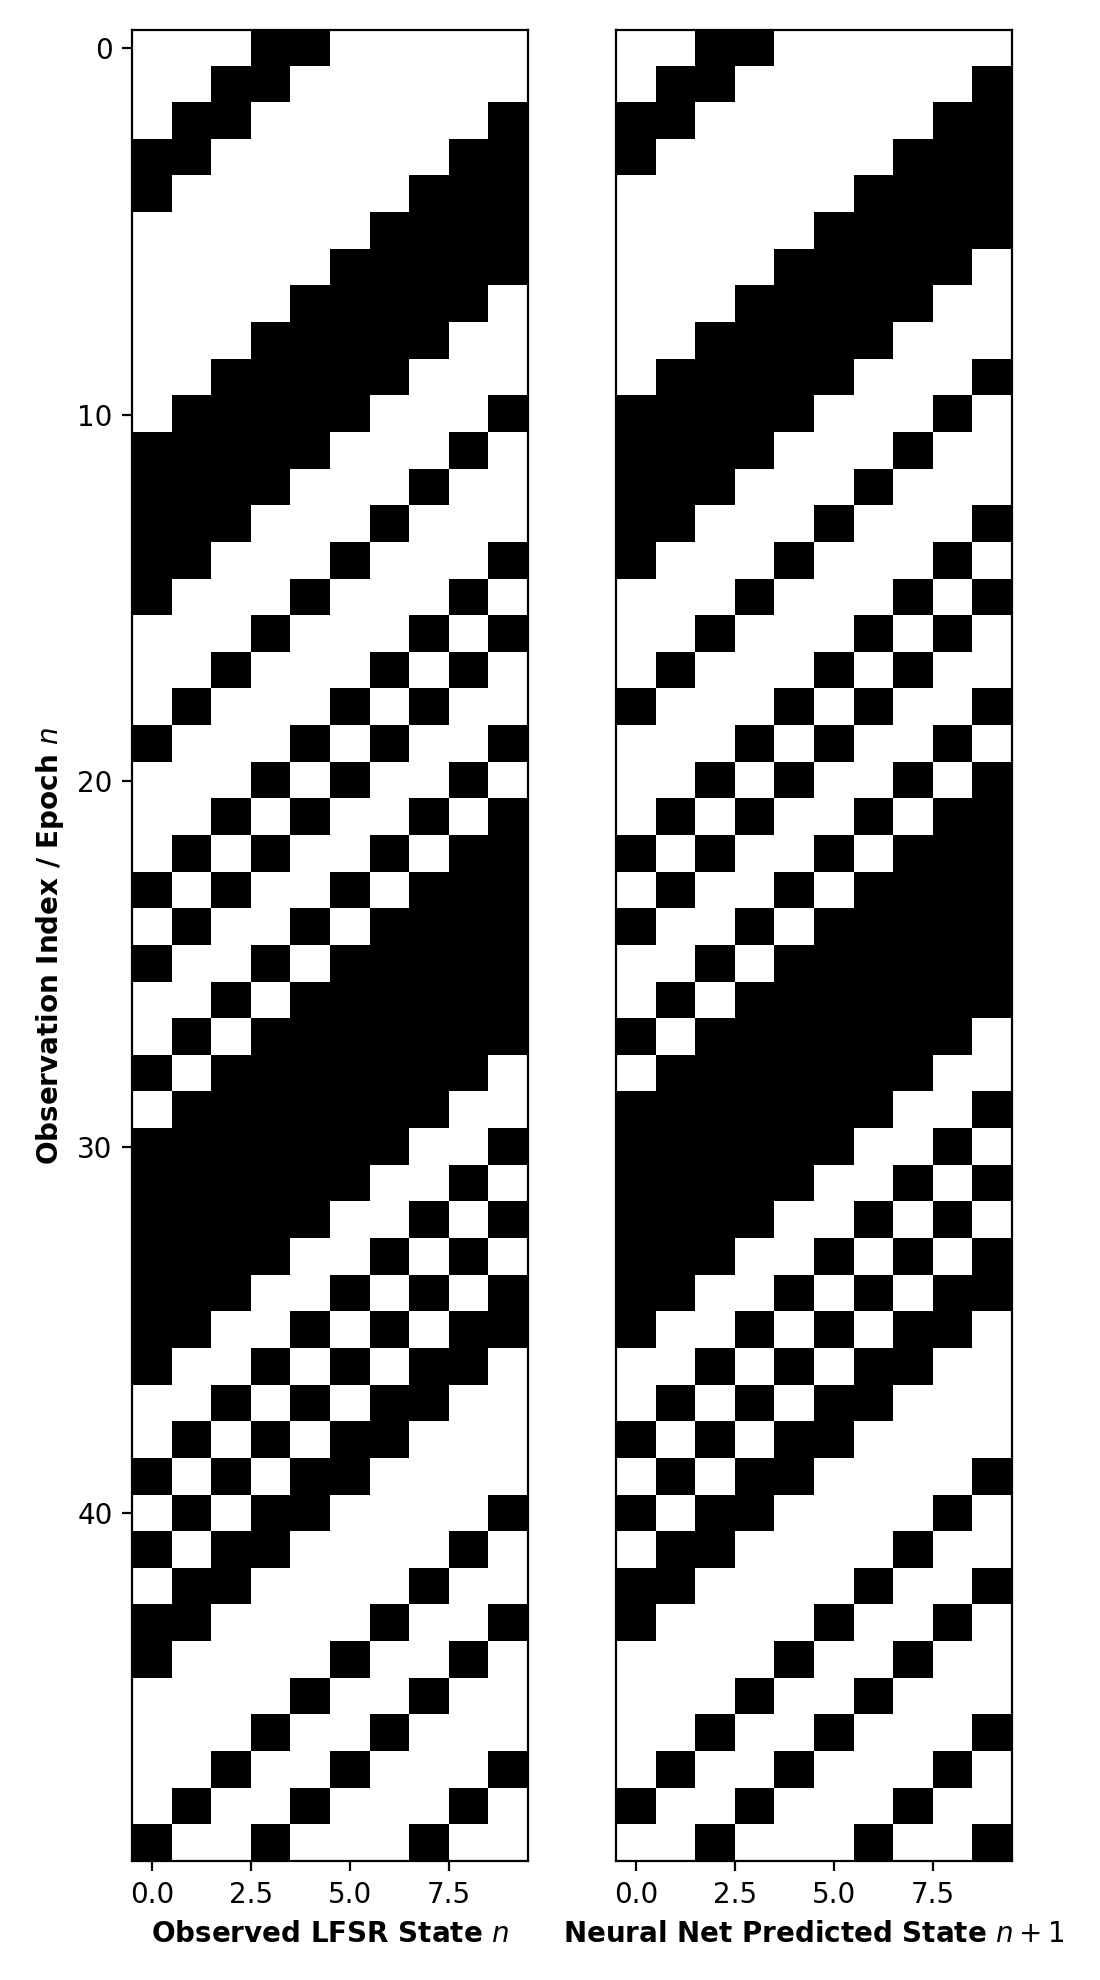

In [12]:
# Plot true n'th vs. predicted (n + 1)'st'...
if plot_prediction_masks:
    
    # Plot LFSR state progression & predicted progression (in parallel)
    true_vs_predicted_masks(idx0=0, idx1=50, input_obs=X,
                      output_activations=output_activations)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


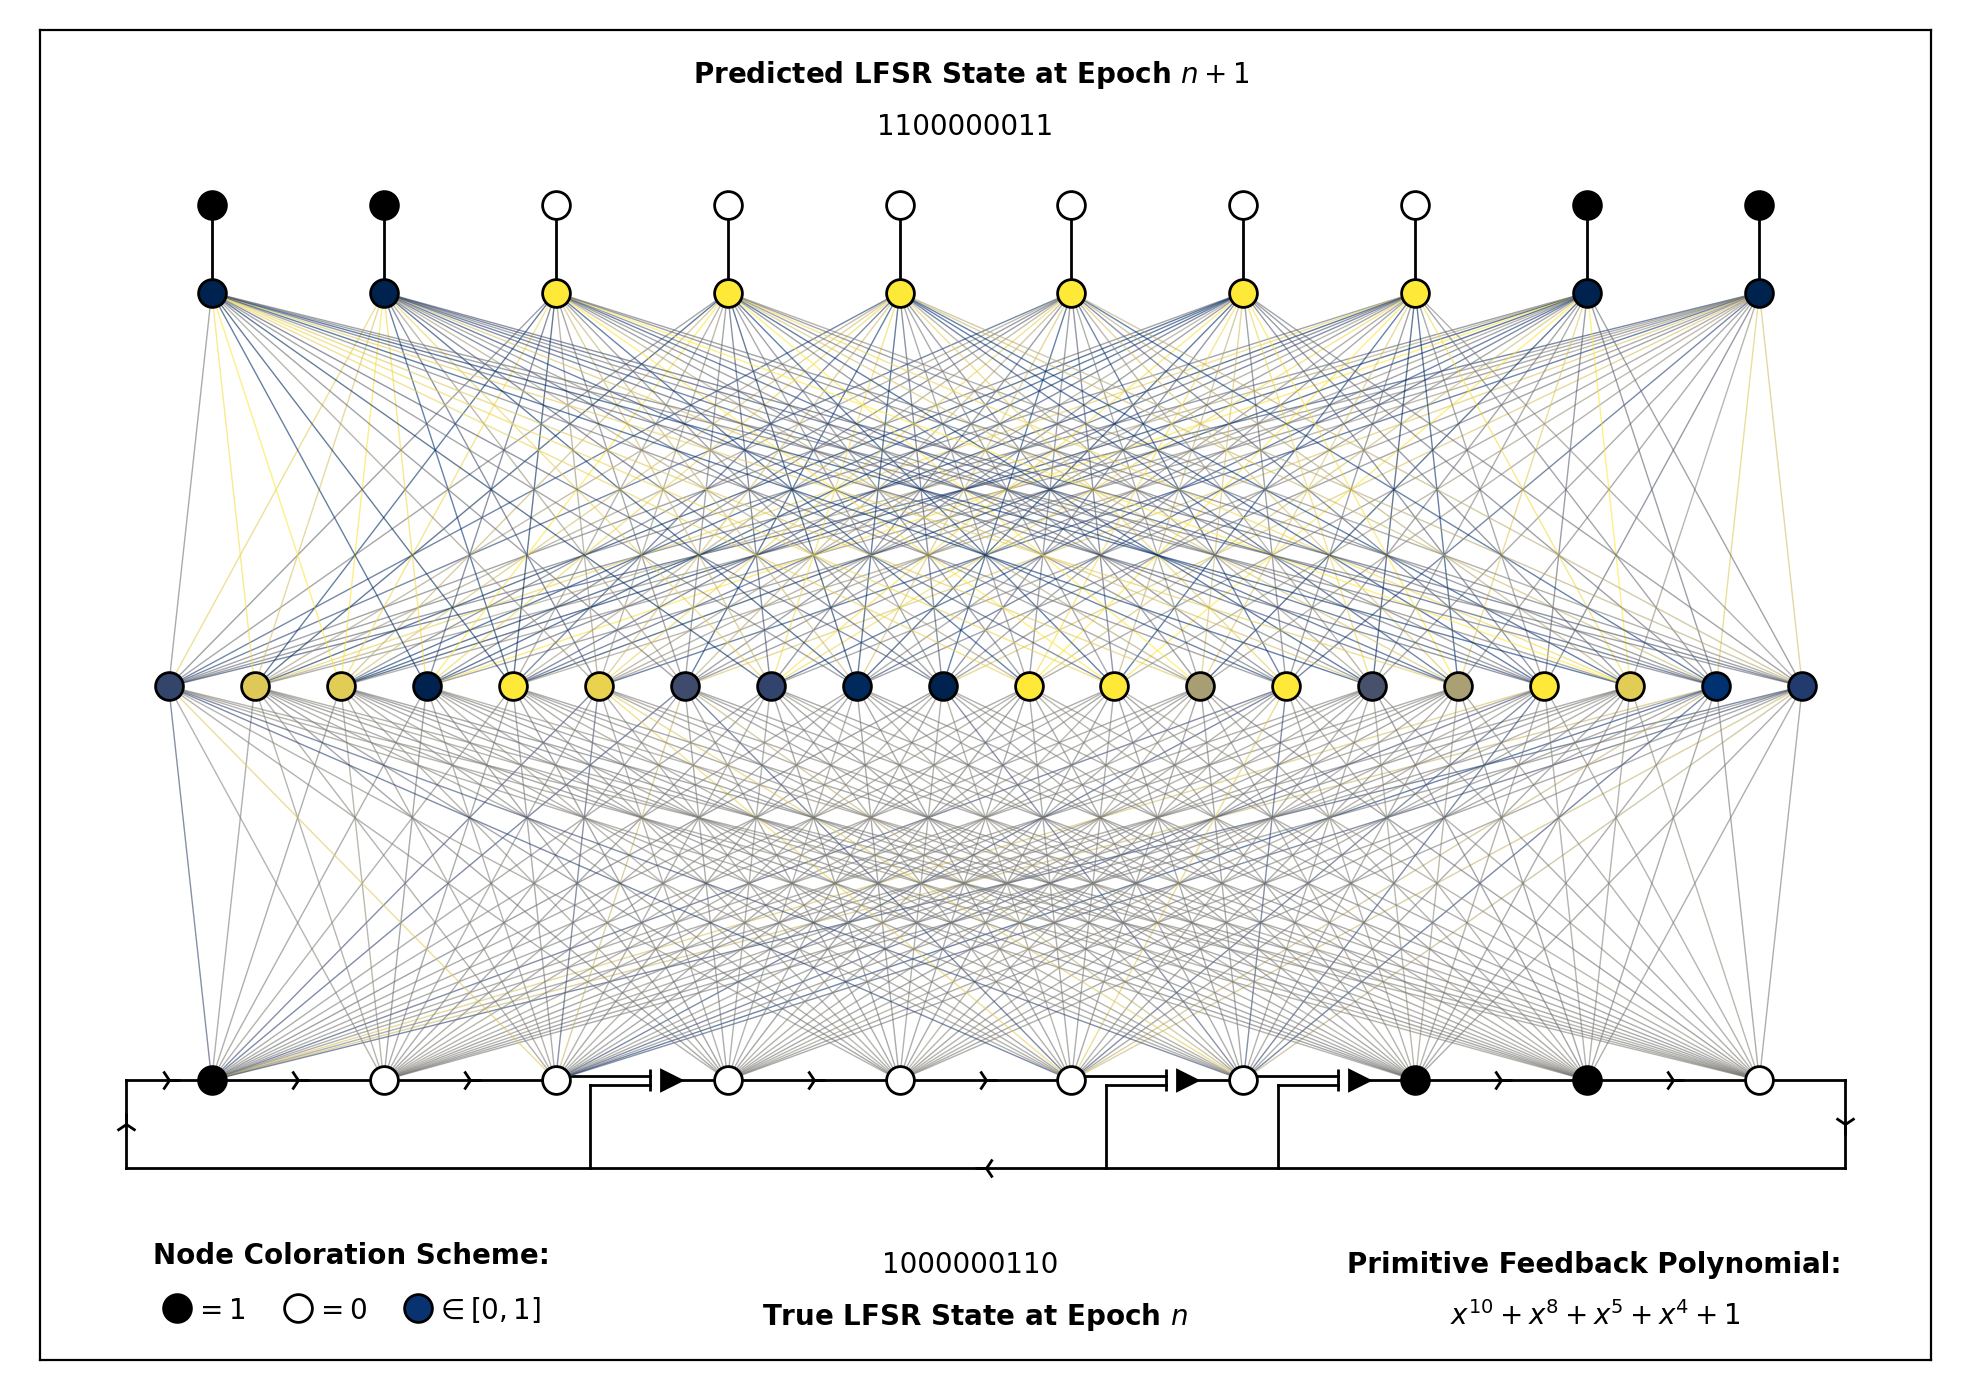

In [14]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 7),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'ylim': [-0.32, 1.2],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 10,
    'link_width': 1,
    'net_link_alpha': 0.6,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

lfsr_prediction_animation(
    lfsr=LFSRs[p], config=config, model=model,
    state_sequence=X, hidden_activations=hidden_activations,
    output_activations=output_activations,
    run_animation=True, interval=1000, blit=True, repeat=True)